# Naval Propulsion Plants Maintenance Prediction

1. [Introduction](#intro)
2. [Explaratory Data Analysis](#eda)
3. [Data Processing](#dp)
4. [Model Selection](#ms)
* [Linear Models](#linear)
* [Ensemble Models](#ensemble)
* [Neural Networks](#nn)
5. [Final Prediction](#prediction)
6. [Conclusion](#conclusion)

<a id="intro"></a>
## Introduction

This work is inspired by paper [Condition-Based Maintenance of Naval Propulsion
Systems with Supervised Data Analysis](https://eprint.ncl.ac.uk/244704).

As a dataset, the Naval Propulsion Plant __Data Driven Model__ simulation records were taken from [UCI repository](https://archive.ics.uci.edu/ml/datasets/Condition+Based+Maintenance+of+Naval+Propulsion+Plants#).

The main issue explored within the project work is __Preventive Maintenance__, a service concept, that implies the life cycle estimation of a certain component. In comparison with the Corrective Maintenance, the PM allows to ensure a component service, repair or substitution before its breakdown, that can raise the efficiency level and reduce costs. 

In the current work, the __Gas Turbine__ and __Compressor__ decay state coefficients are estimated based on number of propulsion system parameters: shaft torque, rate of revolutions, compressor inlet air temperature and pressure, turbine injection control and fuel flow. To build an estimator, the ML and DL techniques are applied.



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [2]:
# reading the sensors data
raw = []
with open('data/data.txt') as file:
    for row in file:
        raw.append(row.strip().split('   '))

In [3]:
# reading the features description
features = open('data/features.txt')
features.read().splitlines()

['1 - Lever position (lp) [ ]',
 '2 - Ship speed (v) [knots]',
 '3 - Gas Turbine shaft torque (GTT) [kN m]',
 '4 - Gas Turbine rate of revolutions (GTn) [rpm]',
 '5 - Gas Generator rate of revolutions (GGn) [rpm]',
 '6 - Starboard Propeller Torque (Ts) [kN]',
 '7 - Port Propeller Torque (Tp) [kN]',
 '8 - HP Turbine exit temperature (T48) [C]',
 '9 - GT Compressor inlet air temperature (T1) [C]',
 '10 - GT Compressor outlet air temperature (T2) [C]',
 '11 - HP Turbine exit pressure (P48) [bar]',
 '12 - GT Compressor inlet air pressure (P1) [bar]',
 '13 - GT Compressor outlet air pressure (P2) [bar]',
 '14 - Gas Turbine exhaust gas pressure (Pexh) [bar]',
 '15 - Turbine Injecton Control (TIC) [%]',
 '16 - Fuel flow (mf) [kg/s]',
 '17 - GT Compressor decay state coefficient.',
 '18 - GT Turbine decay state coefficient. ']

In [4]:
data = pd.DataFrame(raw, columns=['lp', 'v', 'gtt', 'gtn', 'ggn', 'ts', 'tp', 't48',
                                  't1', 't2', 'p48', 'p1', 'p2', 'pexh', 'tic', 'mf', 'y_1', 'y_2'], dtype = float)

<a id='eda'></a>
## Exploratory Data Analysis

In [5]:
data.shape

(11934, 18)

In [6]:
data.describe()

,lp,v,gtt,gtn,ggn,ts,tp,t48,t1,t2,p48,p1,p2,pexh,tic,mf,y_1,y_2
count,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.0,11934.000000,11934.000000,1.193400e+04,11934.000000,11934.000000,11934.000000,11934.000000,11934.00000,11934.0000
mean,5.166667,15.000000,27247.498685,2136.289256,8200.947312,227.335768,227.335768,735.495446,288.0,646.215331,2.352963,9.980000e-01,12.297123,1.029474,33.641261,0.662440,0.97500,0.9875
std,2.626388,7.746291,22148.613155,774.083881,1091.315507,200.495889,200.495889,173.680552,0.0,72.675882,1.084770,2.533635e-13,5.337448,0.010390,25.841363,0.507132,0.01472,0.0075
min,1.138000,3.000000,253.547000,1307.675000,6589.002000,5.304000,5.304000,442.364000,288.0,540.442000,1.093000,9.980000e-01,5.828000,1.019000,0.000000,0.068000,0.95000,0.9750
25%,3.144000,9.000000,8375.883750,1386.758000,7058.324000,60.317000,60.317000,589.872750,288.0,578.092250,1.389000,9.980000e-01,7.447250,1.020000,13.677500,0.246000,0.96200,0.9810
50%,5.140000,15.000000,21630.659000,1924.326000,8482.081500,175.268000,175.268000,706.038000,288.0,637.141500,2.083000,9.980000e-01,11.092000,1.026000,25.276500,0.496000,0.97500,0.9875
75%,7.148000,21.000000,39001.426750,2678.079000,9132.606000,332.364750,332.364750,834.066250,288.0,693.924500,2.981000,9.980000e-01,15.658000,1.036000,44.552500,0.882000,0.98800,0.9940
max,9.300000,27.000000,72784.872000,3560.741000,9797.103000,645.249000,645.249000,1115.797000,288.0,789.094000,4.560000,9.980000e-01,23.140000,1.052000,92.556000,1.832000,1.00000,1.0000


Judging by the data main statistics, the _t1_ and _p1_ features (the GT compressor inlet air temperature and pressure) are constant at the levels of 288 degrees Celcium and 0.998 bars respectively, so these features can be omitted during the analysis.

All the features are of a numerical type, so no encoding techniques should be performed on the data.

In [7]:
# removing constant features
data.drop(['t1', 'p1'], 1, inplace = True)

In [8]:
# checking the number of missing values
data.isnull().sum().to_frame().T

,lp,v,gtt,gtn,ggn,ts,tp,t48,t2,p48,p2,pexh,tic,mf,y_1,y_2
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


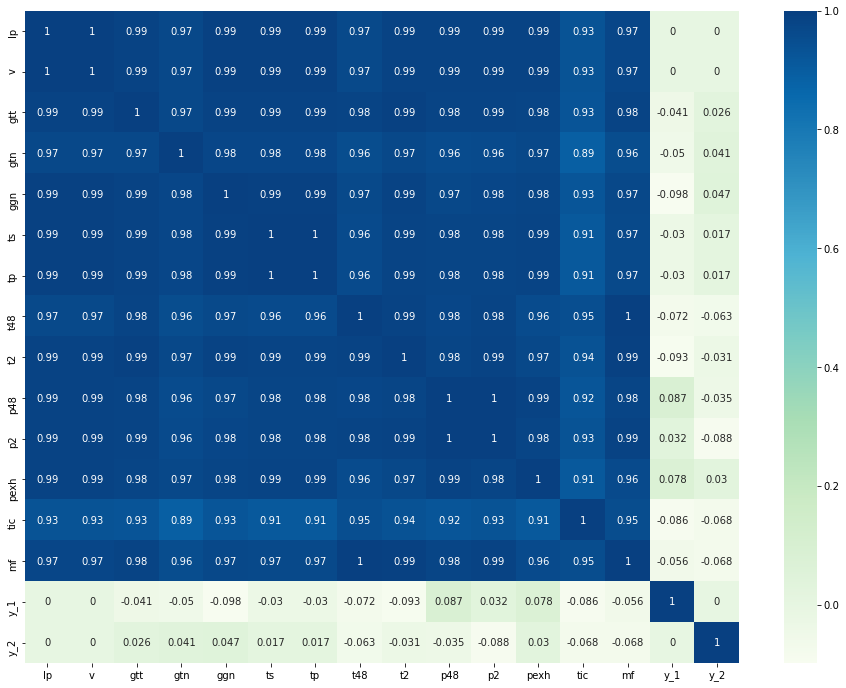

In [9]:
# plotting the correlation matrix
plt.figure(figsize=(16,12))
sns.heatmap(data.corr('spearman'), cmap='GnBu', annot = True)
plt.show()

As it can be seen from the correlation matrix, the following features have strong linear correlation between each other:
* lever position and ship speed; 
* gas turbine torque and starboard and portside torques;
... 

All the features are slightly correlated with the target functions. 

In total, the data is highly correlated, that might cause the problem while fitting the linear model. To avoid the issue, feature selection should be conducted.

__Important!!!__ During the model selection, I tried to fit the models with only 5 selected features (see below), but the accuracy was lower in comparison with the models fitted with all the data presented in the set.

For the future analysis, only several features are kept:
* gas turbine shaft torque (as a torque feature);
* turbine exit temperature (as a temperature feature);
* turbine exit pressure (as a pressure feature);
* turbine injecton control (TIC);
* fuel flow.

Let's take a look at some features distributions.

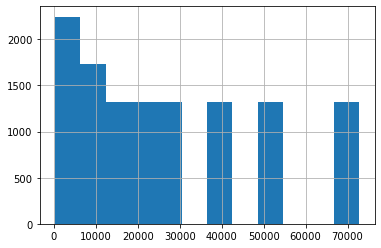

In [10]:
plt.hist(data.gtt, bins = 12)
plt.grid()
plt.show()

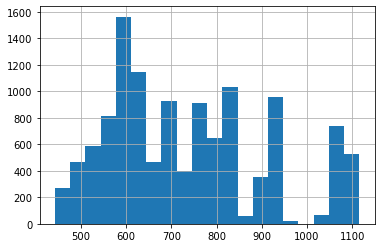

In [11]:
plt.hist(data.t48, bins = 20)
plt.grid()
plt.show()

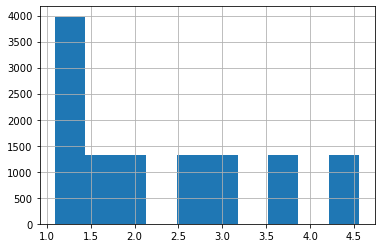

In [12]:
plt.hist(data.p48, bins = 10)
plt.grid()
plt.show()

<a id='dp'></a>
## Data Preprocessing

In [13]:
X = data.iloc[:,:-2]
y_1 = data.iloc[:,-2].values
y_2 = data.iloc[:,-1].values

In [14]:
# scaling the data to have zero mean and unit variance
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)

<a id='ms'></a>
## Model Selection

The following models are built and evaluated in order to choose different approaches to regression problem:
1. *Linear Regression* - just a simple linear model with different regularization terms;
2. *Ensemble Models* - Random Forst and XGBoost Regressors;
3. *Neural Networks* - Shallow NN and Deep NN.

For Linear Regression and Ensemble Models Grid Search technqiue is used to find the optimal hyperparameters values. 

Cross validation is used to initially estimate the model performance. Final estimation is done in the Prediction chapter.

In [15]:
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

<a id='linear'></a>
## Linear Models

### Linear Regression

Ordinary Least Squares algorithm

In [16]:
est = LinearRegression(n_jobs=-1)
cross_val_score(est, X, y_1, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.5s finished


-0.005009634534446037

### Ridge

Linear regression algorithm with L2-regularization

In [17]:
est = Ridge(alpha=0.001)
cross_val_score(est, X, y_1, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


-0.005012637251203854

<a id='ensemble'></a>
## Ensemble Models

### XGBoost

The XGBoost hyperparameters are tuned using Grid Search.

In [18]:
grid = {'n_estimators':[150, 200, 250], 'learning_rate':[0.01, 0.05, 0.1, 0.5, 1], 'max_depth':[5,7,9]}
est = GridSearchCV(XGBRegressor(), grid, n_jobs=-1, cv=5, verbose=1)
est.fit(X, y_1)
est.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  1.9min finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
cross_val_score(est.best_estimator_, X, y_1, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.5s finished


-0.002078336975334917

### Random Forest

The Random Forest hyperparameters are tuned using Grid Search.

In [20]:
grid = {'n_estimators':[100, 150, 200, 250]}
est = GridSearchCV(RandomForestRegressor(), grid, n_jobs=-1, cv=5, verbose=1)
est.fit(X, y_1)
est.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   59.6s finished


RandomForestRegressor(n_estimators=150)

In [21]:
cross_val_score(est.best_estimator_, X, y_1, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   20.8s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.5s finished


-0.00202346226428769

<a id='nn'></a>
## Neural Networks

__Important!__ The NNs built within the project is a rough presentation of Deep Learning applications for regression tasks. Fine tuning of the networks is not a subject of the current work, thus, a Shallow NN with only one Dense layer and a Deep NN with five Dense layers and one Dropout layer are explored. 

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1

In [23]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(X, y_1, test_size=0.2)
y_train_2, y_test_2 = train_test_split(y_2, test_size=.2)

In [24]:
def plot_accuracy_curve(history):
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['mae','val_mae'], loc='upper right')
    plt.title('MAE')
    plt.grid()
    plt.show()

### Shallow Neural Network

In [25]:
stop = EarlyStopping('mean_absolute_error', patience=5)

In [26]:
snn = Sequential([
    Dense(128, activation='relu', input_shape = X_train[1].shape),
    Dense(1, activation='sigmoid')
])

snn.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])

snn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1920      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [27]:
snn_history = snn.fit(X_train, y_train_1, batch_size=128, epochs=500, validation_data=(X_test, y_test_1), verbose=0,
                     callbacks=[stop])

In [28]:
snn.evaluate(X_test, y_test_1, batch_size=128, verbose=1)

19/19 [==============================] - 0s 1ms/step - loss: 0.0028 - mean_absolute_error: 0.0028


[0.002831403398886323, 0.002831403398886323]

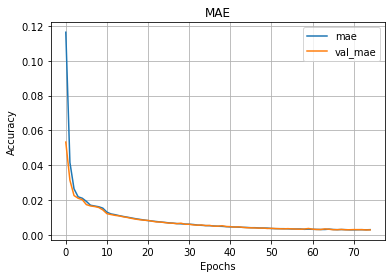

In [29]:
plot_accuracy_curve(snn_history)

### Deep Neural Network

In [31]:
dnn = Sequential([
    Dense(128, activation='relu', input_shape=X_train[1].shape),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

dnn.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])

dnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               1920      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 166,785
Trainable params: 166,785
Non-trainable params: 0
________________________________________________

In [32]:
dnn_history = dnn.fit(X_train, y_train_1, batch_size=256, epochs=500, validation_data=(X_test, y_test_1), verbose=0)

In [33]:
dnn.evaluate(X_test, y_test_1, batch_size=128, verbose=1)

19/19 [==============================] - 0s 469us/step - loss: 0.0028 - mean_absolute_error: 0.0028


[0.002762895543128252, 0.002762895543128252]

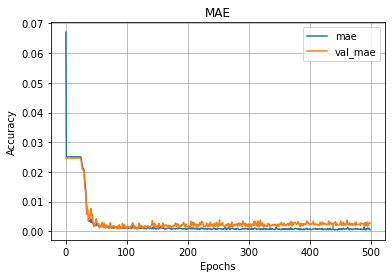

In [34]:
plot_accuracy_curve(dnn_history)

<a id='prediction'></a>
## Final Prediction

In [35]:
# ML algorithms prediction function
def predict(est, X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    est.fit(X_train, y_train)
    y_pred = est.predict(X_test)
    print('MSE:', mean_squared_error(y_test, y_pred))
    print('MAE:', mean_absolute_error(y_test, y_pred))
    df = pd.DataFrame([y_test, y_pred]).T
    df.rename(columns={0:'true', 1:'pred'}, inplace=True)
    df['error'] = abs(df.pred - df.true).round(4)
    df.sort_values('error', ascending = False, inplace=True)
    return df

In [36]:
# DL algorithms prediction function
def evaluate(model, X=X_test, y=y_test_1, batch_size=128):
    y_pred = model.predict(X).flatten()
    print('MSE:', mean_squared_error(y, y_pred))
    print('MAE:', mean_absolute_error(y, y_pred))
    df = pd.DataFrame([y, y_pred.flatten()]).T
    df.rename(columns={0:'true', 1:'pred'}, inplace=True)
    df['error'] = abs(df.pred - df.true).round(4)
    df.sort_values('error', ascending = False, inplace=True)
    return df

### Compressor decay state coefficient prediction

In [37]:
# OLS
est = LinearRegression(n_jobs=-1)
predict(est, X, y_1)

MSE: 3.462702851131436e-05
MAE: 0.004627747394058918


,true,pred,error
1751,0.950,0.969710,0.0197
1670,1.000,0.980374,0.0196
926,1.000,0.980461,0.0195
970,0.951,0.970070,0.0191
2262,0.951,0.969687,0.0187
...,...,...,...
2315,0.976,0.975971,0.0000
805,0.985,0.984959,0.0000
2122,0.976,0.976045,0.0000
1403,0.976,0.975953,0.0000


In [38]:
# Ridge
est = Ridge(alpha=0.001)
predict(est, X, y_1)

MSE: 3.381416872760337e-05
MAE: 0.004575650266389215


,true,pred,error
1988,1.000,0.980702,0.0193
1410,0.950,0.968789,0.0188
2120,0.951,0.969751,0.0188
501,0.996,0.977554,0.0184
848,0.951,0.969411,0.0184
...,...,...,...
1483,0.970,0.970011,0.0000
2352,0.988,0.987953,0.0000
234,0.971,0.971036,0.0000
2341,0.985,0.984984,0.0000


In [50]:
# XGB
est = XGBRegressor(n_estimators=250, max_depth=5, learning_rate=0.5)
predict(est, X, y_1)

MSE: 1.9163471895958235e-06
MAE: 0.0009699834496794167


,true,pred,error
1187,0.999,0.983505,0.0155
1630,0.962,0.952089,0.0099
2360,0.986,0.976189,0.0098
97,0.999,1.007262,0.0083
2078,1.000,0.992875,0.0071
...,...,...,...
883,0.956,0.955989,0.0000
234,0.980,0.979979,0.0000
1771,0.968,0.967982,0.0000
1573,0.965,0.964951,0.0000


In [40]:
# RandomForest
est = RandomForestRegressor(n_estimators=150)
predict(est, X, y_1)

MSE: 9.470472652794276e-07
MAE: 0.0004996648512777262


,true,pred,error
977,0.994,0.980120,0.0139
1824,1.000,0.990740,0.0093
402,0.997,0.987907,0.0091
1832,0.992,0.984847,0.0072
618,0.964,0.971020,0.0070
...,...,...,...
2108,0.970,0.970000,0.0000
445,0.971,0.970967,0.0000
1005,0.969,0.969013,0.0000
453,0.991,0.991020,0.0000


In [41]:
# SNN
evaluate(snn)

MSE: 1.4570912546272286e-05
MAE: 0.002831403071080294


,true,pred,error
1877,1.000,0.985335,0.0147
41,0.999,0.984666,0.0143
219,1.000,0.986081,0.0139
290,0.998,0.984353,0.0136
608,1.000,0.986894,0.0131
...,...,...,...
1139,0.961,0.961018,0.0000
1016,0.951,0.950956,0.0000
1505,0.988,0.988030,0.0000
264,0.986,0.985964,0.0000


In [42]:
# DNN
evaluate(dnn)

MSE: 9.572622154692642e-06
MAE: 0.002762897448505755


,true,pred,error
837,0.985,0.979546,0.0055
1608,0.985,0.979544,0.0055
882,0.984,0.978541,0.0055
2088,0.986,0.980541,0.0055
149,0.984,0.978541,0.0055
...,...,...,...
138,0.950,0.950024,0.0000
470,0.951,0.950993,0.0000
1008,0.953,0.953043,0.0000
954,0.951,0.951033,0.0000


### Turbine decay state coefficient prediction

In [43]:
# OLS
est = LinearRegression(n_jobs=-1)
predict(est, X, y_2)

MSE: 4.933485965136956e-06
MAE: 0.0016838846883390243


,true,pred,error
1962,1.000,0.990826,0.0092
1622,0.996,0.987180,0.0088
436,0.991,0.982319,0.0087
290,0.996,0.987608,0.0084
1347,0.996,0.987743,0.0083
...,...,...,...
875,0.985,0.985012,0.0000
533,0.997,0.997003,0.0000
919,0.990,0.990022,0.0000
1945,0.984,0.984042,0.0000


In [44]:
# Ridge
est = Ridge(alpha=0.001)
predict(est, X, y_2)

MSE: 5.505015434030395e-06
MAE: 0.001753013496301211


,true,pred,error
1361,0.998,0.988291,0.0097
2247,1.000,0.990405,0.0096
1882,0.997,0.987521,0.0095
140,1.000,0.990497,0.0095
1767,0.995,0.985713,0.0093
...,...,...,...
1712,0.988,0.987967,0.0000
597,0.982,0.981959,0.0000
1546,0.979,0.978977,0.0000
685,0.982,0.981957,0.0000


In [51]:
# XGB
est = XGBRegressor(n_estimators=250, max_depth=5, learning_rate=0.5)
predict(est, X, y_2)

MSE: 1.1585603174085028e-06
MAE: 0.000745542835480108


,true,pred,error
1777,0.978,0.988531,0.0105
2205,0.977,0.984915,0.0079
999,0.975,0.982726,0.0077
2068,0.976,0.982599,0.0066
1613,0.976,0.981965,0.0060
...,...,...,...
2170,0.989,0.988990,0.0000
486,0.986,0.985967,0.0000
2178,0.976,0.975986,0.0000
1340,0.984,0.984011,0.0000


In [46]:
# RandomForest
est = RandomForestRegressor(n_estimators=150)
predict(est, X, y_2)

MSE: 4.1818881906626256e-07
MAE: 0.00030988409440021607


,true,pred,error
1118,0.975,0.982047,0.0070
710,0.997,0.990260,0.0067
1981,0.975,0.981393,0.0064
1238,0.975,0.980820,0.0058
1191,0.980,0.985807,0.0058
...,...,...,...
1059,0.995,0.995007,0.0000
1058,0.989,0.989007,0.0000
1891,0.986,0.986020,0.0000
1895,0.986,0.985967,0.0000


In [53]:
# SNN
snn.fit(X_train, y_train_2, batch_size=128, epochs=500, validation_data=(X_test, y_test_2), verbose=0, callbacks=[stop])
evaluate(snn, y=y_test_2)

MSE: 5.7554012844299326e-05
MAE: 0.006441809832225753


,true,pred,error
1909,0.975,0.991511,0.0165
1538,0.975,0.991358,0.0164
1458,0.975,0.991200,0.0162
2049,0.975,0.991104,0.0161
1384,0.975,0.990994,0.0160
...,...,...,...
317,0.990,0.989991,0.0000
2043,0.987,0.986964,0.0000
1307,0.991,0.991004,0.0000
843,0.991,0.990995,0.0000


In [54]:
# DNN
dnn.fit(X_train, y_train_2, batch_size=128, epochs=500, validation_data=(X_test, y_test_2), verbose=0, callbacks=[stop])
evaluate(dnn, y=y_test_2)

MSE: 5.5279970912879836e-05
MAE: 0.006388910562062197


,true,pred,error
387,1.000,0.983842,0.0162
352,1.000,0.984242,0.0158
321,1.000,0.984518,0.0155
1224,1.000,0.984580,0.0154
915,0.999,0.983746,0.0153
...,...,...,...
2231,0.987,0.987024,0.0000
170,0.987,0.986986,0.0000
2003,0.987,0.986961,0.0000
1294,0.987,0.986979,0.0000


<a id='conclusion'></a>
## Conclusion

During the project work, the propulsion plants preventive maintenance possibility was examined. The gas compressor and turbine decay state coefficients were predicted based on the Data Driven Model GT parameters.

The model showed the best results is __Random Forest__ algorithm with the performance:
MSE = 9.5e-07, and MAE = 0.0005 for Compressor Decay State Coefficient;
MSE = 4.2e-07, and MAE = 0.0003 for Turbine Decay State Coefficient.

Neural Networks also have high performance, moreover, with a fine tuning even higher scores can be achieved.

The performance of each model is accurate enough to be used in the industrial applications. The final model can be chosen between the explored based on the time and power efficiency.


It turned out, that the models fitted with the 14 features (all except constant compressor inlet air temperature and pressure features) show more accurate results than the ones fitted with the chosen set of 5 parameters (in accordance with the correlation matrix).